In [1]:
import cv2

In [2]:
net = cv2.dnn.readNetFromTensorflow("human-pose-estimation\graph_opt.pb")  # Load a TF model

In [3]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]
# copy from COCO dataset of openpose (OpenCV)
# https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.py

In [4]:
import matplotlib.pyplot as plt 

(-0.5, 859.5, 816.5, -0.5)

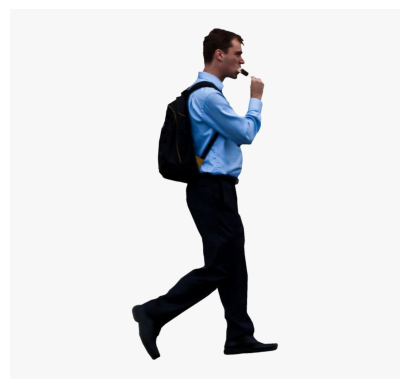

In [57]:
img = cv2.imread("images/walking.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

## Using DNN

In [50]:
def pose_estimation(frame,thr=0.2):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    # print(frameWidth, frameHeight)
    net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    # 127.5 is the mean value of the image (255/2)
    # 368 is the size of the image
    out = net.forward() # get the output of the network
    
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements
    # 19 is the number of body parts 
    assert(len(BODY_PARTS) == out.shape[1])

    # get all the points of the body parts that have confidence > thresholds
    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        
        # minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(src[, mask])
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        # get the location 
        x = (frameWidth * point[0]) / out.shape[3] 
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
    # the pose pairs are the connections between the body parts
    # make sure that the points are not None and then connect (draw) the lines
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
    # put the name of the part 
    for name,id in BODY_PARTS.items():
        if points[id] is not None:
            if name[0] == "L": 
                cv2.putText(frame, name, points[id], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0),2)
            else :
                # move it to the left to easy to show
                cv2.putText(frame, name, (points[id][0]-50, points[id][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255),2)
    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')

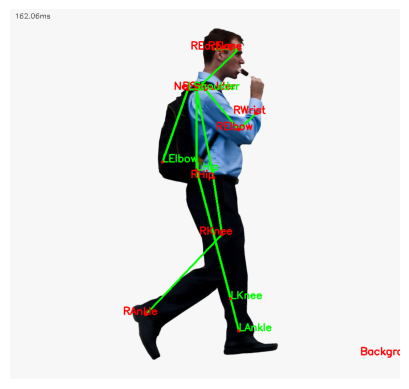

In [58]:
pose_estimation(img.copy(),0.1)